In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Keras APIs
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import models
from tensorflow import keras
import tensorflow as tf

from configs import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
df_all_images = images_pipeline()

I have 351 image of me
I have 346 image of others
Now total number of images is 697


In [3]:
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)

The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


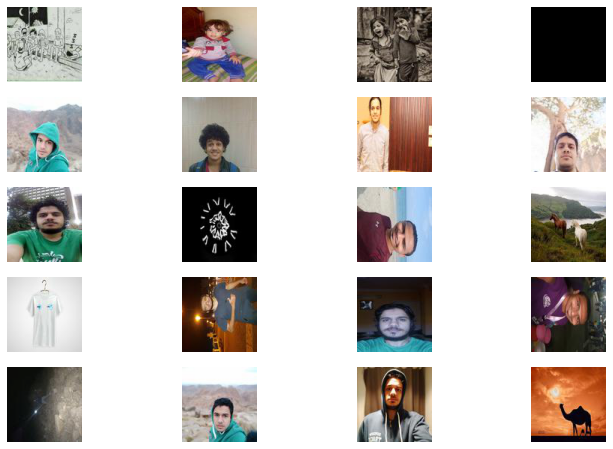

In [4]:
display_some_images(X_train)

# Previous

We have used Logistic regression along with Grid Search to find the best parameters and the result we get as you can see from training to validation set.

<img src="images/lo_1.png">

# Now time for Shallow NN

## Shallow NN from Scratch

In [5]:

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [6]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # number of features we have
    n_h = 4
    n_y = Y.shape[0] # The result is either 0 or 1
    return (n_x, n_h, n_y)

In [7]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 30000
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters:
            W1 
            b1 
            W2 
            b2 
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.

    
    W1 = np.random.randn(n_h, n_x) * .01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * .01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [9]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
parameters      = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"].shape))
print("b1 = " + str(parameters["b1"].shape))
print("W2 = " + str(parameters["W2"].shape))
print("b2 = " + str(parameters["b2"].shape))

W1 = (4, 30000)
b1 = (4, 1)
W2 = (1, 4)
b2 = (1, 1)


In [10]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.matmul(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [11]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
parameters      = initialize_parameters(n_x, n_h, n_y)
A2, cache = forward_propagation(X_train, parameters)

print(cache['Z1'].shape, cache['A1'].shape, cache['Z2'].shape, cache['A2'].shape)

(4, 600) (4, 600) (1, 600) (1, 600)


In [12]:
def compute_cost(A2, Y, parameters):
    """    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost
    
    """
    
    m = Y.shape[1] # number of example

    cost = (-1/m) * np.dot(Y, np.log(A2).T)
                                     
    return cost

In [13]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
parameters      = initialize_parameters(n_x, n_h, n_y)
A2, cache = forward_propagation(X_train, parameters)

print("cost = " + str(compute_cost(A2, y_train, parameters)))

cost = [[0.34482788]]


In [14]:
def backward_propagation(parameters, cache, X, Y):
    """    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X : input
    Y : output
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    A1 = cache['A1']
    A2 = cache['A2']
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.matmul(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.multiply(np.matmul(W2.T, dZ2), (1-np.square(A1)))
    dW1 = (1/m) * np.matmul(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [15]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
parameters      = initialize_parameters(n_x, n_h, n_y)
A2, cache = forward_propagation(X_train, parameters)

grads = backward_propagation(parameters, cache, X_train, y_train)
print ("dW1 = "+ str(grads["dW1"].shape))
print ("db1 = "+ str(grads["db1"].shape))
print ("dW2 = "+ str(grads["dW2"].shape))
print ("db2 = "+ str(grads["db2"].shape))

dW1 = (4, 30000)
db1 = (4, 1)
dW2 = (1, 4)
db2 = (1, 1)


In [16]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [17]:
(n_x, n_h, n_y) = layer_sizes(X_train, y_train)
parameters      = initialize_parameters(n_x, n_h, n_y)
A2, cache = forward_propagation(X_train, parameters)

grads = backward_propagation(parameters, cache, X_train, y_train)

parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"].shape))
print("b1 = " + str(parameters["b1"].shape))
print("W2 = " + str(parameters["W2"].shape))
print("b2 = " + str(parameters["b2"].shape))

W1 = (4, 30000)
b1 = (4, 1)
W2 = (1, 4)
b2 = (1, 1)


In [18]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, learning_rate=1.2, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    

    for i in range(0, num_iterations):
         
        A2, cache = forward_propagation(X, parameters)
        
        cost = compute_cost(A2, Y, parameters)
 
        grads = backward_propagation(parameters, cache, X, Y)
 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [19]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

In [20]:
parameters = nn_model(X_train, y_train, 4,learning_rate=1.5, num_iterations=3000, print_cost=True)
print("W1 = " + str(parameters["W1"].shape))
print("b1 = " + str(parameters["b1"].shape))
print("W2 = " + str(parameters["W2"].shape))
print("b2 = " + str(parameters["b2"].shape))

Cost after iteration 0: 0.344828
Cost after iteration 1000: 0.338833
Cost after iteration 2000: 0.337833
W1 = (4, 30000)
b1 = (4, 1)
W2 = (1, 4)
b2 = (1, 1)


In [21]:
predictions = predict(parameters, X_train)
print("predictions Training f1 score = " + str(f1_score(y_train.reshape(-1,1), predictions.reshape(-1,1))))

predictions = predict(parameters, X_val)
print("predictions Validation f1 score = " + str(f1_score(y_val.reshape(-1,1), predictions.reshape(-1,1))))

predictions Training f1 score = 0.6757369614512472
predictions Validation f1 score = 0.697986577181208


## Shallow NN Using Keras API

In [22]:
def keras_shallow_model(hidden_acti):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[0],)))
    model.add(Dense(4, activation=hidden_acti))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [23]:
model = keras_shallow_model('tanh')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 120004    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 120,009
Trainable params: 120,009
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5),
             metrics=['binary_accuracy'])
history = model.fit(X_train.T, y_train.T, batch_size=X_train.shape[1], epochs=50, validation_data=(X_val.T, y_val.T))

model.save('saved_model_weights/Shallow_NN_tanh_and_sigmoid.h5')

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.7626 - binary_accuracy: 0.5283 - val_loss: 1.4461 - val_binary_accuracy: 0.4639
Epoch 2/50
1/1 [==============================] - 0s 56ms/step - loss: 1.3542 - binary_accuracy: 0.5017 - val_loss: 0.7188 - val_binary_accuracy: 0.5361
Epoch 3/50
1/1 [==============================] - 0s 53ms/step - loss: 0.7381 - binary_accuracy: 0.4983 - val_loss: 0.7343 - val_binary_accuracy: 0.4639
Epoch 4/50
1/1 [==============================] - 0s 67ms/step - loss: 0.7206 - binary_accuracy: 0.5017 - val_loss: 0.6986 - val_binary_accuracy: 0.5361
Epoch 5/50
1/1 [==============================] - 0s 73ms/step - loss: 0.7111 - binary_accuracy: 0.4983 - val_loss: 0.7136 - val_binary_accuracy: 0.4639
Epoch 6/50
1/1 [==============================] - 0s 77ms/step - loss: 0.7050 - binary_accuracy: 0.5017 - val_loss: 0.6926 - val_binary_accuracy: 0.5361
Epoch 7/50
1/1 [==============================] - 0s 72ms/step - loss: 0.7012 - bina

In [25]:
model = keras_shallow_model('relu')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 120004    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 120,009
Trainable params: 120,009
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5),
             metrics=['accuracy'])
history = model.fit(X_train.T, y_train.T, batch_size=X_train.shape[1], epochs=50, validation_data=(X_val.T, y_val.T))

model.save('saved_model_weights/Shallow_NN_relu_and_sigmoid.h5')

Epoch 1/50
1/1 [==============================] - 1s 681ms/step - loss: 0.7801 - accuracy: 0.5100 - val_loss: 68.2084 - val_accuracy: 0.5361
Epoch 2/50
1/1 [==============================] - 0s 49ms/step - loss: 69.7339 - accuracy: 0.4983 - val_loss: 1.5162 - val_accuracy: 0.4639
Epoch 3/50
1/1 [==============================] - 0s 74ms/step - loss: 1.3574 - accuracy: 0.5017 - val_loss: 0.6911 - val_accuracy: 0.5361
Epoch 4/50
1/1 [==============================] - 0s 62ms/step - loss: 0.6940 - accuracy: 0.4983 - val_loss: 0.6918 - val_accuracy: 0.5361
Epoch 5/50
1/1 [==============================] - 0s 59ms/step - loss: 0.6935 - accuracy: 0.4983 - val_loss: 0.6923 - val_accuracy: 0.5361
Epoch 6/50
1/1 [==============================] - 0s 69ms/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6927 - val_accuracy: 0.5361
Epoch 7/50
1/1 [==============================] - 0s 65ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6929 - val_accuracy: 0.5361
Epoch 8/50
1/1 [========

In [27]:
def keras_shallow_model_2(hidden_acti):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[0],)))
    model.add(Dense(512, activation=hidden_acti))
    model.add(Dense(256, activation=hidden_acti))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [28]:
model = keras_shallow_model_2('sigmoid')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               15360512  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 15,492,097
Trainable params: 15,492,097
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=.5),
             metrics=['binary_accuracy'])
history = model.fit(X_train.T, y_train.T, epochs=50, validation_data=(X_val.T, y_val.T))

model.save('saved_model_weights/Shallow_NN_sigmoid_512_256_1__neurons.h5')

Epoch 1/50
19/19 [==============================] - 2s 67ms/step - loss: 1.2085 - binary_accuracy: 0.4800 - val_loss: 0.6917 - val_binary_accuracy: 0.5361
Epoch 2/50
19/19 [==============================] - 1s 58ms/step - loss: 0.6893 - binary_accuracy: 0.5283 - val_loss: 0.6929 - val_binary_accuracy: 0.4639
Epoch 3/50
19/19 [==============================] - 1s 61ms/step - loss: 0.6837 - binary_accuracy: 0.5450 - val_loss: 0.6840 - val_binary_accuracy: 0.4639
Epoch 4/50
19/19 [==============================] - 1s 61ms/step - loss: 0.6766 - binary_accuracy: 0.5533 - val_loss: 0.6763 - val_binary_accuracy: 0.5773
Epoch 5/50
19/19 [==============================] - 1s 62ms/step - loss: 0.6698 - binary_accuracy: 0.5783 - val_loss: 0.7212 - val_binary_accuracy: 0.4639
Epoch 6/50
19/19 [==============================] - 2s 87ms/step - loss: 0.6582 - binary_accuracy: 0.6000 - val_loss: 0.6683 - val_binary_accuracy: 0.5052
Epoch 7/50
19/19 [==============================] - 1s 67ms/step - los

(0.0, 1.0)

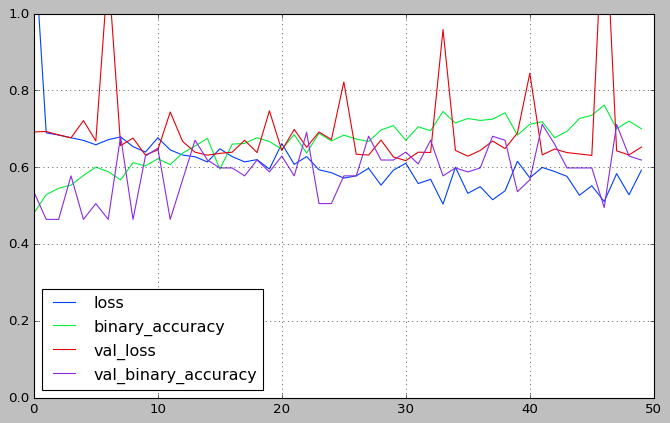

In [37]:
init_2d_graphs('seaborn-bright')
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]